<a href="https://colab.research.google.com/github/Noy-Bo/Cancer-Cell-Segmentation/blob/master/Cancer_Cell_Segmentation_MicroNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

mounting drive, setting root path to PanNuke dataset, setting device to cuda, checking out GPU


In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
root_path = '/content/gdrive/MyDrive/Colab/Cell Segmentation/' 
os.chdir(root_path)
!ls

'Cancer Cell Segmentation Nir.ipynb'   my_checkpoint_dice.pth.tar
 Dataset			       my_checkpoint.pth.tar


In [3]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [4]:
!nvidia-smi

Sun Jul 25 05:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Dataset**
loading files, creating dataloaders, etc..



In [5]:

import torch
from torch.utils.data import Dataset
import numpy as np
import pickle

class PanNukeDataset(Dataset):
    def  __init__(self, image_dir, masks_dir=None, cancer_types_dir=None, transform=None):
        #self.image_dir = image_dir
        #self.masks_dir = masks_dir
        #self.cancer_types_dir = cancer_types_dir
        self.transform = transform

        # Data is pickled into dictionaries ({'images': imgs, 'cancer_types': cancer_types, 'masks':masks}), let's open it up:
        with open(image_dir, mode='rb') as f:  # The with just manages closing of files and etc once finished.
            data_dict = pickle.load(f)  # load the original pickled dataset

        self.images = data_dict['images']
        self.cancer_types = data_dict['cancer_types']
        self.masks = data_dict['masks']

    def __len__(self):
        return self.images.shape[0]

    # returns images,masks   FOR NOW IT DOESN'T RETURN cancer_types!!!
    def __getitem__(self, index):
        image = self.images[index, ...].astype(dtype=np.float32)
        mask = self.masks[index, ...].astype(dtype=np.float32)
        mask[mask > 0] = 1.0

        # Set dimensions from 256x256xCH, to CHx256x256  - CHECK TO BE POSITIVE
        mask = np.moveaxis(mask, -1, 0)
        image = np.moveaxis(image, -1, 0)


        if self.transform is not None :
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]

        return torch.from_numpy(image),torch.from_numpy(mask)

# Creating data loaders:
def load_dataset(batch_size, shuffle_flag, num_workers=None, data_dir=None, transforms=None):
  dataset = PanNukeDataset(data_dir)
  if num_workers is not None :
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag, num_workers=num_workers)
  else :
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag)

  return data_loader

# **Model**
Micro-Net Model configuration (according to the paper, adjusted to 256x256 images)

In [6]:

import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as TNF
import torch.nn.modules
from torch import optim
import time
from torch.utils.data import DataLoader
from torchsummary import summary
import tqdm

# Small useful components:
# this class is to be able to use TNF.interpole within nn.Sequential()
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = TNF.interpolate
        self.size = size
        self.mode = mode

    def forward(self, x):
        return self.interp(x, size=self.size, mode=self.mode, align_corners=False)

# Create the Micro-Net components:
class Group1_B1(nn.Module):
    def __init__(self, in_channels=3):
        super(Group1_B1, self).__init__()

        self.sub_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False), # kernel=5 since we start with 256 imgs, where in paper it's 252
            nn.BatchNorm2d(64), # out_channels=64
            nn.Tanh(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),  # REMOVE?
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ) #124,124,64

        self.sub_block2 = nn.Sequential(
            Interpolate(size=(128,128),mode='bicubic'),
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),  # out_channels=64
            nn.Tanh(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Tanh(),
        )

    def forward(self, orig_input):
        sub_block1 = self.sub_block1(orig_input) # recall it outputs: B,CH,HEIGHT,WIDTH
        sub_block2 = self.sub_block2(orig_input)
        B1 = torch.cat((sub_block1,sub_block2), dim=1) # concat alongside channels dim'
        return B1

class Group1_B2(nn.Module):
    def __init__(self, in_channels=128):
        super(Group1_B2, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 124^2, ch=128,   outputs: 60^2, ch=128
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 60^2, ch=128
            Interpolate(size=(64, 64), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Tanh(),
        )

    def forward(self, B1_input, orig_input):
        sub_block1 = self.sub_block1(B1_input)
        sub_block2 = self.sub_block2(orig_input)
        B2 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B2

class Group1_B3(nn.Module):
    def __init__(self, in_channels=256):
        super(Group1_B3, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 60^2, ch=256,   outputs: 28^2, ch=256
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 28^2, ch=256
            Interpolate(size=(32, 32), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.Tanh(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Tanh(),
        )

    def forward(self, B2_input, orig_input):
        sub_block1 = self.sub_block1(B2_input)
        sub_block2 = self.sub_block2(orig_input)
        B3 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B3

class Group1_B4(nn.Module):
    def __init__(self, in_channels=512):
        super(Group1_B4, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 28^2, ch=512,   outputs: 12^2, ch=512
            nn.Conv2d(in_channels=in_channels, out_channels=512, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 12^2, ch=512
            Interpolate(size=(16, 16), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.Tanh(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Tanh(),
        )

    def forward(self, B3_input, orig_input):
        sub_block1 = self.sub_block1(B3_input)
        sub_block2 = self.sub_block2(orig_input)
        B4 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B4

class Group2_B5(nn.Module):
    def __init__(self, in_channels=1024):
        super(Group2_B5, self).__init__()
        self.sub_block = nn.Sequential(  # gets 12^2, ch=1024,   outputs: 8^2, ch=2048
            nn.Conv2d(in_channels=in_channels, out_channels=2048, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
        )

    def forward(self, B4_input):
        B5 = self.sub_block(B4_input)
        return B5

class Group3_Bi(nn.Module):
    def __init__(self, in_channels_prev_b, in_channels_g1):
        super(Group3_Bi, self).__init__()
        # ------------------- UNSURE HERE REGARDING THE 1ST SUBBLOCK, WE DECONV UP TO 16 THEN CONV TWICE TO 8 THEN AGAIN DECONV UP TO 16?????
        # First-part of the block:
        self.sub_block1 = nn.Sequential(  # gets size^2, #channels, outputs (size*2)^2, #channels/2
            nn.ConvTranspose2d(in_channels=in_channels_prev_b, out_channels=round(in_channels_prev_b / 2),kernel_size=2, stride=2, padding=0), # double x=h,w to 2x X 2x
            nn.Conv2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=3, stride=1, padding=0), # turn to 2x-2 X 2x-2
            # nn.BatchNorm2d(in_channels_prev_b/2),
            nn.Tanh(),
            nn.Conv2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=3, stride=1, padding=0),  # turn to 2x -4 X 2x-4
            # nn.BatchNorm2d(in_channels_prev_b/2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=5, stride=1, padding=0),  # turn back to 2x X 2x,
        )

        # Mid-part of the block:
        self.sub_block2 = nn.ConvTranspose2d(in_channels=in_channels_g1, out_channels=in_channels_g1, kernel_size=5, stride=1, padding=0) # it upsamples by 4 only

        # Third-part of the block:
        self.sub_block3 = nn.Sequential(
            nn.Conv2d(in_channels=round(in_channels_g1*2), out_channels=in_channels_g1, kernel_size=3, stride=1, padding=1), # same conv
            nn.Tanh()
        )

    def forward(self, g1_input, prev_b_input):
        sub_block1 = self.sub_block1(prev_b_input)
        sub_block2 = self.sub_block2(g1_input)
        sub_block3 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        Bi = self.sub_block3(sub_block3)
        return Bi

class Group4_Pa1(nn.Module):
    def __init__(self):
        super(Group4_Pa1, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2), #upsample by 2x
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=64, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b9_input):
        x1 = self.sub_block1(b9_input) # this also goes onwards to Group5
        pa1 = self.sub_block2(x1)
        return pa1, x1

class Group4_Pa2(nn.Module):
    def __init__(self):
        super(Group4_Pa2, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=4), #upsample by 4x
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=128, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b8_input):
        x2 = self.sub_block1(b8_input) # this also goes onwards to Group5
        pa2 = self.sub_block2(x2)
        return pa2, x2

class Group4_Pa3(nn.Module):
    def __init__(self):
        super(Group4_Pa3, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=8, stride=8), #upsample by 8x
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=256, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b7_input):
        x3 = self.sub_block1(b7_input) # this also goes onwards to Group5
        pa3 = self.sub_block2(x3)
        return pa3, x3

class Group5(nn.Module):
    def __init__(self):
        super(Group5, self).__init__()
        self.sub_block = nn.Sequential( #unlike the paper, the input for this stage is 256x256, 448(after concat)
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=448, out_channels=6, kernel_size=3, stride=1, padding=1), #unlike paper ^^
        )

    def forward(self, x1, x2, x3):
        x = torch.cat((x1, x2, x3), dim=1) # concat x1,x2,x3 alongside channels dim'
        p0 = self.sub_block(x)
        return p0

class MicroNet(nn.Module):
    def __init__(self):
        super(MicroNet, self).__init__()
        self.group1_b1 = Group1_B1()
        self.group1_b2 = Group1_B2()
        self.group1_b3 = Group1_B3()
        self.group1_b4 = Group1_B4()
        self.group2 = Group2_B5()
        self.group3_b6 = Group3_Bi(in_channels_prev_b=2048, in_channels_g1=1024)
        self.group3_b7 = Group3_Bi(in_channels_prev_b=1024, in_channels_g1=512)
        self.group3_b8 = Group3_Bi(in_channels_prev_b=512, in_channels_g1=256)
        self.group3_b9 = Group3_Bi(in_channels_prev_b=256, in_channels_g1=128)
        self.group4_pa1 = Group4_Pa1()
        self.group4_pa2 = Group4_Pa2()
        self.group4_pa3 = Group4_Pa3()
        self.group5 = Group5()

    def forward(self, x):
        # Propagate through G1:
        b1 = self.group1_b1(x)
        b2 = self.group1_b2(b1, x)
        b3 = self.group1_b3(b2, x)
        b4 = self.group1_b4(b3, x)

        # Propagate through G2:
        b5 = self.group2(b4)

        # Propagate through G3:
        b6 = self.group3_b6(b4, b5)
        b7 = self.group3_b7(b3, b6)
        b8 = self.group3_b8(b2, b7)
        b9 = self.group3_b9(b1, b8)

        # Propagate through G4:
        pa1, x1 = self.group4_pa1(b9)
        pa2, x2 = self.group4_pa2(b8)
        pa3, x3 = self.group4_pa3(b7)

        # Propagate through G5:
        p0 = self.group5(x1, x2, x3)

        return p0, pa1, pa2, pa3  # recall that p0 = main output, pa1,pa2,pa3 = auxiliary outputs
        

# **Train, Evaluation & Other model Utilities**
loss functions configurations, train epoch function ..


In [10]:
import matplotlib.pyplot as plt



def train(model, loader, opt, criterion,scheduler, epoch):
    epoch_loss = 0
    epoch_acc = 0

    # Train the model (turn training-mode on..)
    model.train()

    with tqdm.tqdm(total=len(loader), file=sys.stdout) as pbar:
        for (images, masks) in loader:
            images = images.to(device)
            masks = masks.to(device)

            # reinitialize gradients..
            opt.zero_grad()

            # Calculation of loss (according to paper):
            p0, pa1, pa2, pa3 = model(images) # Pi.shape, 256x256x5
            masks = torch.argmax(masks, dim=1)
            #loss = criterion(output, masks)
            l0 = criterion(p0, masks)
            l1 = criterion(pa1, masks)
            l2 = criterion(pa2, masks)
            l3 = criterion(pa3, masks)
            loss = l0+(l1+l2+l3)/epoch
            countable_loss = l0+l1+l2+l3 # Since original loss will always decrease as we proceed with higher epochs
            # Backpropagation
            loss.backward()

            # Calculate accuracy
            #acc = calculate_accuracy(output, labels)

            # update weights according to gradients
            opt.step()

            epoch_loss += countable_loss.item()
            #epoch_acc += acc.item

            pbar.update()
            pbar.set_description(f'train loss={countable_loss.item():.3f}')

        pbar.set_description(f'train loss={epoch_loss / len(loader):.3f}')
    scheduler.step()

    return epoch_loss / len(loader), epoch_acc / len(loader)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(load_model_path, model):
    print("=> Loading checkpoint")
    if torch.cuda.is_available():
        checkpoint = torch.load(load_model_path)
        model.load_state_dict(checkpoint["state_dict"])
    else:
        checkpoint = torch.load(TRAINED_MODEL_PATH + "my_checkpoint.pth.tar", map_location='cpu')
        model.load_state_dict(checkpoint["state_dict"])

# Can be used for multiclass...
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss ( hence the 1 - dice_score ).
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


# **Data Utilities**
For Visualizations and etc

In [18]:
import cv2


# VISUALIZING SAMPLES - designed for input that is the dataloader output, for raw input cancel moveaxis
def vis_sample(image, masks):
    fig, axs = plt.subplots(1,7)
    fig.tight_layout()
    axs[0].imshow(np.moveaxis(image.numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
    #masks = np.moveaxis(masks,0,-1)
    masks = masks.permute(1,2,0)
    axs[1].imshow(masks[:,:,0], cmap="gray"); axs[1].set_title("Neoplastic cells")
    axs[2].imshow(masks[:,:,1], cmap="gray"); axs[2].set_title("Inflammatory")
    axs[3].imshow(masks[:,:,2], cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
    axs[4].imshow(masks[:,:,3], cmap="gray"); axs[4].set_title("Dead Cells")
    axs[5].imshow(masks[:,:,4], cmap="gray"); axs[5].set_title("Epithelial")
    axs[6].imshow(masks[:,:,5], cmap="gray"); axs[6].set_title("Background")
    plt.show()

# VISUALIZING PREDICTIONS - visualizing network output on a random sample.
def vis_predictions(data_loader, model, model_type='unet'):
    model.eval()
    image_gt_batch, masks_gt_batch = iter(data_loader).next()

    if model_type == "micronet" :
        pred_masks_batch, _, _, _ = model(image_gt_batch) # Grabbing only PO predictions.
    else:
        pred_masks_batch = model(image_gt_batch)

    for i in range(image_gt_batch.shape[0]): # looping on batch_size
      print("\t\t\t SAMPLE: {}".format(str(i)))
      image = image_gt_batch[i,...] # 3,256,256
      pred_masks = pred_masks_batch[i,...] # 6,256,256
      one_hot_masks = torch.nn.functional.one_hot(torch.argmax(pred_masks, dim=0))
      one_hot_masks = one_hot_masks.permute(2, 0, 1)
      one_hot_masks *= 250  # white color?

      print("Prediction:")
      fig, axs = plt.subplots(1,7)
      fig.set_size_inches(18.5, 10.5)
      fig.tight_layout()
      axs[0].imshow(np.moveaxis(image.numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
      axs[1].imshow(one_hot_masks[0,:,:].cpu().detach().numpy(), cmap="gray"); axs[1].set_title("Neoplastic cells")
      axs[2].imshow(one_hot_masks[1,:,:].cpu().detach().numpy(), cmap="gray"); axs[2].set_title("Inflammatory")
      axs[3].imshow(one_hot_masks[2,:,:].cpu().detach().numpy(), cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
      axs[4].imshow(one_hot_masks[3,:,:].cpu().detach().numpy(), cmap="gray"); axs[4].set_title("Dead Cells")
      axs[5].imshow(one_hot_masks[4,:,:].cpu().detach().numpy(), cmap="gray"); axs[5].set_title("Epithelial")
      axs[6].imshow(one_hot_masks[5,:,:].cpu().detach().numpy(), cmap="gray"); axs[6].set_title("Background")
      plt.show()

      print("Ground Truth:")
      vis_sample(image,masks_gt_batch[i,...]) # visualizing gt (ground truth)

# Visualizes a random batch from a given data-loader
def visualize_segmented_ground_truth(data_loader, model, model_type):
    # Colors according to the PanNuke-dataset paper:
    colors = {"1neoplastic":(255,0,0), "2inflammatory":(0,255,0), "3connective":(0,0,255), "4dead":(255,255,0), "5epithelial":(255,102,0)}
    model.eval()

    # Grab model predictions of a random batch:
    images_gt_batch, masks_gt_batch = iter(data_loader).next()
    images_gt_batch = images_gt_batch.to(device)
    masks_gt_batch = masks_gt_batch.to(device)

    if model_type == "micronet":
        masks_pred_batch, _, _, _ = model(images_gt_batch)  # Grabbing only PO predictions.
    else:
        masks_pred_batch = model(images_gt_batch)

    # Turn masks maps to edges maps:
    pred_masks_edges = np.zeros((masks_gt_batch.shape))
    gt_masks_edges = np.zeros((masks_gt_batch.shape))

    for i in range(images_gt_batch.shape[0]): # looping on batch_size
        # Grab the i'th prediction masks (which hold scores) and adjust it to final prediction (one hots...)
        ith_pred = masks_pred_batch[i, ...] # CH,H,W
        ith_onehot_pred_masks = torch.nn.functional.one_hot(torch.argmax(ith_pred, dim=0)) # returns HxWxCH
        ith_onehot_pred_masks = ith_onehot_pred_masks.permute(2, 0, 1) # sets dimensions so that for example, dim=2 will be now dim=0, hence will get CH,H,W

        # Grab the i'th gt masks (already onehots)
        ith_onehot_gt_masks = masks_gt_batch[i, ...]

        # Adjust pixels' values:
        ith_onehot_pred_masks[ith_onehot_pred_masks > 0] = 255
        ith_onehot_gt_masks[ith_onehot_gt_masks > 0] = 255

        # Turn prediction masks to edges maps:
        ith_onehot_pred_masks = ith_onehot_pred_masks.cpu().numpy().astype(dtype=np.uint8)
        for j in range(ith_onehot_pred_masks.shape[0]):
            edges = cv2.Canny(ith_onehot_pred_masks[j, ...], 1, 4)   # CHECK Canny's parameters...  CAN BE IMPROVED
            pred_masks_edges[i, j, ...] = edges

        # Turn gt masks to edges maps:
        ith_onehot_gt_masks = ith_onehot_gt_masks.cpu().numpy().astype(dtype=np.uint8)
        for j in range(ith_onehot_gt_masks.shape[0]):
            edges = cv2.Canny(ith_onehot_gt_masks[j, ...], 1, 4)  # CHECK Canny's parameters...  CAN BE IMPROVED
            gt_masks_edges[i, j, ...] = edges


    # Given edges-masks-maps, paint every image in batch, according to gt_edges_masks & pred_edges_masks:
    segmented_gt_images = np.copy(images_gt_batch.cpu()) # B,CH,H,W
    segmented_pred_images = np.copy(images_gt_batch.cpu())

    # For every image in batch:
    for i in range(images_gt_batch.shape[0]):
        # For every edged-mask:
        for j, color in zip(range(gt_masks_edges.shape[0]-1), colors.keys()): #-1 since we don't paint using the "Backround mask"
            # Paint gt & pred images:
            segmented_gt_images[i, :, gt_masks_edges[i, j, ...] > 0] = colors[color]
            segmented_pred_images[i, :, pred_masks_edges[i, j, ...] > 0] = colors[color]

    # Adjust segmented images dimensions for imshow() operations:
    segmented_gt_images = np.transpose(segmented_gt_images, (0,2,3,1)) # from B,CH,H,W to B,H,W,CH (np.transpose is np version of torch.permute)
    segmented_pred_images = np.transpose(segmented_pred_images, (0,2,3,1))

    # Visualize GT vs PRED:
    fig, axarr = plt.subplots(2, segmented_gt_images.shape[0], figsize=(20, 9))
    fig.suptitle('First row= Ground Truth, Second row= Prediction', fontsize=14)
    fig.tight_layout()
    for i in range(segmented_gt_images.shape[0]):
        gt_img = segmented_gt_images[i, ...].astype(dtype=np.uint8)
        pred_img = segmented_pred_images[i, ...].astype(dtype=np.uint8)

        axarr[0, i].axis('off')
        axarr[0, i].imshow(gt_img)
        axarr[1, i].imshow(pred_img)
        axarr[1, i].axis('off')

    plt.show()

# **Main (training)**


In [12]:

# Variables:
BATCH_SIZE = 5
NUM_WORKERS = 4
EPOCHS = 30
LEARNING_RATE=0.001
TRAIN = False
DATA_PATH = 'C:/Users/nirya/PycharmProjects/PanNuke/Final_Dataset/'
TRAINED_MODEL_PATH = 'C:/Users/nirya/PycharmProjects/Cell Segmentation/'
LOSS_FUNC = dice_loss
MODEL_TO_SAVE_NAME = 'my_checkpoint_dice.pth.tar'

# On local:
# train_dir = DATA_PATH +'train_pickled_data'
# val_dir = DATA_PATH + 'val_pickled_data'
# test_dir = DATA_PATH + 'test_pickled_data'

# On Colab:
train_dir = 'Dataset/train_pickled_data'
val_dir = 'Dataset/val_pickled_data'
test_dir = 'Dataset/test_pickled_data'

# Set up device:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

# Grab loaders (ON CUDA):
train_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=train_dir)
val_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=val_dir)
test_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=test_dir)

model = MicroNet().to(device)
summary(model, (3, 256, 256))

# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, last_epoch=-1, verbose=False)
loss_func = nn.CrossEntropyLoss()


if TRAIN :
    for epoch in range(EPOCHS):
        print("Epoch-%d: " % (epoch))
        train_loss, train_acc = train(model, train_loader, optimizer, LOSS_FUNC, scheduler, epoch+1, )
        print(f"train loss={train_loss}, epoch={epoch}")

        # Save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        save_checkpoint(checkpoint, MODEL_TO_SAVE_NAME)

        # val_loss, val_acc = evaluate(model, val_loader, loss_func)
        # print(f"train loss={train_loss}, epoch={epoch}")
else :
    # On Local:
    # load_checkpoint(TRAINED_MODEL_PATH+"my.checkpoint_dice.pth.tar", model)
    # On Colab:
    load_checkpoint("my_checkpoint_dice.pth.tar", model)
    

    




cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 252, 252]           4,800
       BatchNorm2d-2         [-1, 64, 252, 252]             128
              Tanh-3         [-1, 64, 252, 252]               0
            Conv2d-4         [-1, 64, 248, 248]         102,400
       BatchNorm2d-5         [-1, 64, 248, 248]             128
              Tanh-6         [-1, 64, 248, 248]               0
         MaxPool2d-7         [-1, 64, 124, 124]               0
       Interpolate-8          [-1, 3, 128, 128]               0
            Conv2d-9         [-1, 64, 126, 126]           1,728
      BatchNorm2d-10         [-1, 64, 126, 126]             128
             Tanh-11         [-1, 64, 126, 126]               0
           Conv2d-12         [-1, 64, 124, 124]          36,864
             Tanh-13         [-1, 64, 124, 124]               0
        Group1_B1-14        [-1, 1

# **Visualizing Predictions vs Ground Truth**

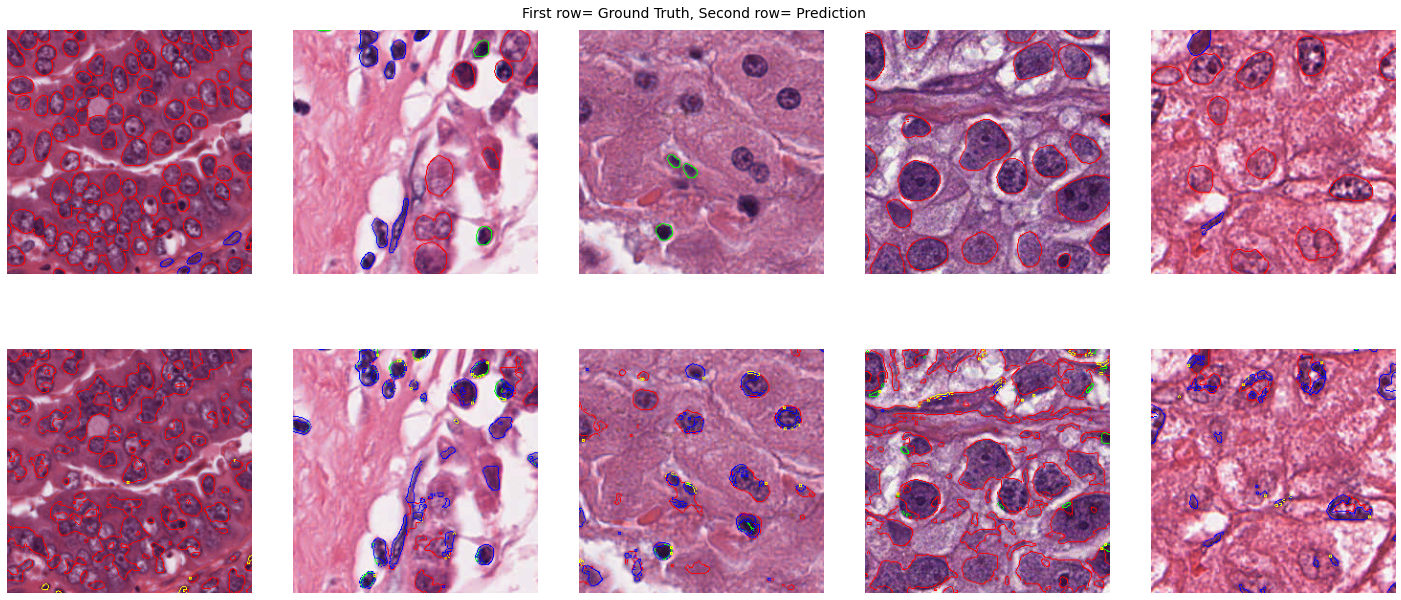

In [20]:

visualize_segmented_ground_truth(test_loader, model, "micronet")
#vis_predictions(test_loader, model, "micronet")